In [49]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.autograd import Variable

import numpy as np
import cvxpy as cp

from free_flyer.free_flyer import FreeFlyer
import pickle, os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
#load train/test data
prob = FreeFlyer() #use default config, pass different config file oth.
config_fn = './free_flyer/config/default.p'

config_file = open(config_fn,'rb')
dataset_name, _, _ = pickle.load(config_file); config_file.close()

relative_path = os.getcwd()
dataset_fn = relative_path + '/free_flyer/data/' + dataset_name

train_file = open(dataset_fn+'/train.p','rb')
# p_train, x_train, u_train, y_train, c_train, times_train = pickle.load(train_file)
train_data = pickle.load(train_file)
train_file.close()
x_train = train_data[1]
y_train = train_data[3]

test_file = open(dataset_fn+'/test.p','rb')
# p_test, x_test, u_test, y_test, c_test, times_test = pickle.load(test_file)
test_data = pickle.load(test_file)
p_test, x_test, u_test, y_test, c_test, times_test = test_data
test_file.close()

n_test = x_test.shape[0]

# task-specific MLOPT

In [38]:
from solvers.mlopt_ff import MLOPT_FF

In [39]:
system = 'free_flyer'
prob_features = ['x0', 'obstacles']
mlopt_ts_obj = MLOPT_FF(system, prob, prob_features)

n_features = 4 + 4*prob.n_obs + prob.n_obs
mlopt_ts_obj.construct_strategies(n_features, train_data)
print(mlopt_ts_obj.n_strategies)

1728


In [40]:
mlopt_ts_obj.setup_network()

fn_saved = 'models/mloptff_free_flyer_20200702_1648.pt' # for data_files
fn_saved = 'models/mloptff_free_flyer_20200715_1631.pt'        # new spaced apart data
fn_saved = 'mloptff_free_flyer_20200727_1052.pt'
mlopt_ts_obj.load_network(fn_saved)

mlopt_ts_obj.model

Loading presaved classifier model from mloptff_free_flyer_20200727_1052.pt


FFNet(
  (activation): ReLU()
  (layers): ModuleList(
    (0): Linear(in_features=44, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=1728, bias=True)
  )
)

In [43]:
mlopt_ts_obj.training_params['TRAINING_ITERATIONS'] = 500
mlopt_ts_obj.train(verbose=True)
print(mlopt_ts_obj.model_fn)

loss:   2.7860002517700195,   acc:  0.375
loss:   2.5509347915649414,   acc:  0.375
loss:   2.377227306365967,   acc:  0.375
loss:   2.182856798171997,   acc:  0.46875
loss:   2.452882766723633,   acc:  0.3125
loss:   1.656607747077942,   acc:  0.5
loss:   2.089160680770874,   acc:  0.5
loss:   1.8749475479125977,   acc:  0.5


KeyboardInterrupt: 

In [ ]:
n_succ = 0
count = 0
gurobi_mlopt_fail = 0

costs_mlopt = []
total_time_mlopt = []
num_solves_mlopt = []

cost_ratios_mlopt = []

for ii in range(n_test):
    if ii % 200 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals, optvals = mlopt_ts_obj.forward(prob_params)

        count += 1
        if prob_success:
            n_succ += 1
            costs_mlopt += [cost]
            total_time_mlopt += [total_time]
            num_solves_mlopt += [n_evals]

            true_cost = c_test[ii]
            cost_ratios_mlopt += [cost / true_cost]
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('Solver failed at {}'.format(ii))
        gurobi_mlopt_fail += 1
        continue

costs_mlopt = np.array(costs_mlopt)
cost_ratios_mlopt = np.array(cost_ratios_mlopt)
total_time_mlopt = np.array(total_time_mlopt)
num_solves_mlopt = np.array(num_solves_mlopt, dtype=int)

mlopt_percentage = 100 * float(n_succ) / float(count)

In [64]:
mlopt_percentage

80.54711246200608

# image encodings

In [5]:
from solvers.mlopt_ff import MLOPT_FF

In [53]:
system = 'free_flyer'
prob_features = ['x0', 'obstacles_map']

mlopt_cnn = MLOPT_FF(system, prob, prob_features)

n_features = 4
mlopt_cnn.construct_strategies(n_features, train_data)
print(mlopt_cnn.n_strategies)

1728


In [54]:
mlopt_cnn.setup_network()

fn_saved = 'models/mloptff_free_flyer_20200706_0823.pt'  # old dataset
fn_saved = 'models/mloptff_free_flyer_20200716_0708.pt'   # New spaced out dataset
fn_saved = 'None' # horizon of 11
fn_saved = 'mloptff_free_flyer_20200726_1455.pt'
mlopt_cnn.load_network(fn_saved)

mlopt_cnn.model

Loading presaved classifier model from mloptff_free_flyer_20200726_1455.pt


CNNet(
  (conv_activation): ReLU()
  (ff_activation): ReLU()
  (conv_layers): ModuleList(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
    (2): Conv2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
  )
  (ff_layers): ModuleList(
    (0): Linear(in_features=260, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=1728, bias=True)
  )
)

In [8]:
mlopt_cnn.training_params['TRAINING_ITERATIONS'] = 750
mlopt_cnn.train(train_data=train_data, verbose=True)

KeyboardInterrupt: 

In [12]:
prob_params = {}
idx = np.random.randint(test_data[1].shape[0])
for k in p_test.keys():
    prob_params[k] = p_test[k][idx]

prob_success, cost, total_time, n_evals, optvals = mlopt_cnn.forward(prob_params)

if prob_success:
    print(cost)
else:
    print('Failed')

213.5196173261296


In [ ]:
n_succ = 0
count = 0
gurobi_mlopt_fail = 0

costs_cnn = []
total_time_cnn = []
num_solves_cnn = []

cost_ratios_cnn = []
costs_ip = []
total_time_ip = []
num_solves_ip = []

for ii in range(n_test):
    if ii % 1000 == 0:
        print('{} / {}'.format(ii,n_test))
    prob_params = {}
    for k in p_test.keys():
        prob_params[k] = p_test[k][ii]

    try:
        prob_success, cost, total_time, n_evals, optvals = mlopt_cnn.forward(prob_params)

        count += 1
        if prob_success:
            n_succ += 1
            costs_cnn += [cost]
            total_time_cnn += [total_time]
            num_solves_cnn += [n_evals]

            true_cost = c_test[ii]
            costs_ip += [true_cost]
            total_time_ip += [times_test[ii]]

            cost_ratios_cnn += [cost / true_cost]
    except (KeyboardInterrupt, SystemExit):
        raise
    except:
        print('Solver failed at {}'.format(ii))
        gurobi_mlopt_fail += 1
        continue

costs_cnn = np.array(costs_cnn)
cost_ratios_cnn = np.array(cost_ratios_cnn)
total_time_cnn = np.array(total_time_cnn)
num_solves_cnn = np.array(num_solves_cnn, dtype=int)

costs_ip = np.array(costs_ip)
total_time_ip = np.array(total_time_ip)
num_solves_ip = np.array(num_solves_ip, dtype=int)

cnn_percentage = 100 * float(n_succ) / float(count)

0 / 1000
Solver failed at 3
Solver failed at 12
Solver failed at 25


In [62]:
prob_params = {}
for k in p_test.keys():
    prob_params[k] = p_test[k][94]

prob_success, cost, total_time, n_evals, optvals = mlopt_cnn.forward(prob_params, solver=cp.MOSEK)
prob_success

True

In [51]:
cnn_percentage

82.61758691206543

In [15]:
gurobi_mlopt_fail

22

# Results

In [67]:
import math
import seaborn as sns
sns.set(font_scale=1.5, font="serif", style="whitegrid")
import pandas as pd

flierprops = {'alpha':0.2}

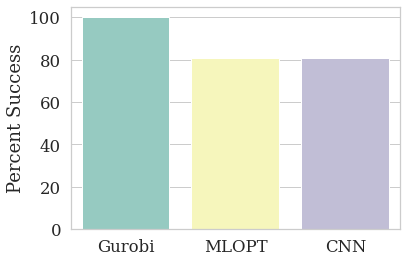

In [68]:
results = {'Gurobi':[100.], 'MLOPT':[mlopt_percentage], 'CNN':[cnn_percentage]}
results = pd.DataFrame(results)

ax1 = sns.barplot(data=results, palette="Set3", label='small')
ax1.set(xlabel="", ylabel="Percent Success")

plt.tight_layout()

figure = ax1.get_figure()
# # figure.savefig("loss.pdf")

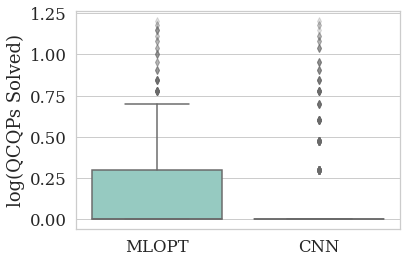

In [69]:
results = {}
results['Policy'] = ['MLOPT']*len(num_solves_mlopt) + ['CNN']*len(num_solves_cnn)
results['Solves'] = np.hstack((np.log10(num_solves_mlopt), np.log10(num_solves_cnn)))
results = pd.DataFrame(results)

ax1 = sns.boxplot(x=results['Policy'], y=results['Solves'], palette="Set3", flierprops=flierprops)                            
ax1.set(xlabel="", ylabel="log(QCQPs Solved)")

plt.tight_layout()

figure = ax1.get_figure()
# figure.savefig("loss.pdf")

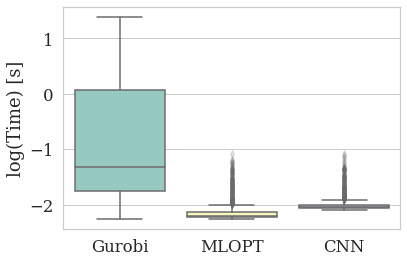

In [70]:
results = {}
results['Policy'] = ['Gurobi']*len(total_time_ip) + ['MLOPT']*len(total_time_mlopt) + \
    ['CNN']*len(total_time_cnn)
results['Time'] = np.hstack((np.log10(total_time_ip), \
    np.log10(total_time_mlopt), np.log10(total_time_cnn)))
results = pd.DataFrame(results)

ax1 = sns.boxplot(x=results['Policy'], y=results['Time'], palette="Set3", flierprops=flierprops)
ax1.set(xlabel="", ylabel="log(Time) [s]")

plt.tight_layout()

figure = ax1.get_figure()
# figure.savefig("loss.pdf")

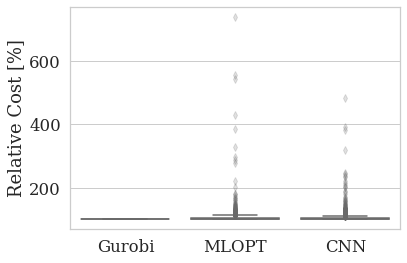

In [71]:
results = {}
results['Policy'] = ['Gurobi']*len(costs_ip) + \
    ['MLOPT']*len(cost_ratios_mlopt) + ['CNN']*len(cost_ratios_cnn)
results['Costs'] = np.hstack((100*np.ones(len(costs_ip)), \
    100*cost_ratios_mlopt, 100*cost_ratios_cnn))
results = pd.DataFrame(results)

ax1 = sns.boxplot(x=results['Policy'], y=results['Costs'], palette="Set3", flierprops=flierprops)
ax1.set(xlabel="", ylabel="Relative Cost [%]")

plt.tight_layout()
# plt.ylim(0, int(math.ceil(np.max(np.maximum(costs_ip, costs_naive_mlopt, costs_mlopt)) / 10.0)) * 10)

figure = ax1.get_figure()
# figure.savefig("loss.pdf")

# Generalization

In [127]:
def obs_intersect(obs_1, obs_2):
    intersect = True
    if obs_1[1] < obs_2[0] or \
        obs_2[1] < obs_1[0] or \
        obs_1[3] < obs_2[2] or \
        obs_2[3] < obs_1[2]:
        intersect = False
    return intersect

def is_free_state(x0, obstacles, posmin, posmax):
    """ Check if x0 is free state given list of obstacles"""
    if any([x0[0] >= obstacle[0] and x0[0] <= obstacle[1] and \
             x0[1] >= obstacle[2] and x0[1] <= obstacle[3] \
             for obstacle in obstacles]):
        return False
    return True

def find_obs(x0, posmin, posmax, n_obs, max_iter=100, ignore_intersection=True):
    """ Given state x0, place obstacles between x0 and posmax"""
    obs = []
    itr = 0
    while len(obs) < n_obs and itr < max_iter:
        xmin = (posmax[0] - border_size - max_box_size)*np.random.rand() + border_size
        xmin = np.max([xmin, x0[0]])
        xmax = xmin + min_box_size  + (max_box_size - min_box_size)*np.random.rand()
        ymin = (posmax[1] - border_size - max_box_size)*np.random.rand() + border_size
        ymin = np.max([ymin, x0[1]])
        ymax = ymin + min_box_size  + (max_box_size - min_box_size)*np.random.rand()
        obstacle = np.array([xmin - box_buffer, xmax + box_buffer, \
                        ymin - box_buffer, ymax + box_buffer])

        intersecting = False
        for obs_2 in obs:
            intersecting = obs_intersect(obstacle, obs_2)
            if intersecting:
                break
        if ignore_intersection:
            intersecting = False

        if is_free_state(x0, [obstacle], posmin, posmax) and not intersecting:
            obs.append(obstacle)
        itr += 1

    if len(obs) is not n_obs:
        return []
    return obs

def findIC(obstacles, posmin, posmax, velmin, velmax):
    """ Given list of obstacles, find IC that is collision free"""
    IC_found = False
    while not IC_found:
        r0 = posmin + 0.5*(posmax-posmin)*np.random.rand(2)
        if not any([r0[0] >= obstacle[0] and r0[0] <= obstacle[1] and \
             r0[1] >= obstacle[2] and r0[1] <= obstacle[3] \
             for obstacle in obstacles]):
            IC_found = True
    x0 = np.hstack((r0, velmin + (velmax-velmin)*np.random.rand(2)))
    return x0

def random_obs(n_obs, posmin, posmax, border_size, \
              min_box_size, max_box_size, max_iter=1000):
    """ Generate random list of obstacles in workspace """
    obstacles = []
    itr = 0
    while itr < max_iter and len(obstacles) is not n_obs:
        xmin = (posmax[0] - border_size - max_box_size)*np.random.rand() + border_size
        xmax = xmin + min_box_size  + (max_box_size - min_box_size)*np.random.rand()
        ymin = (posmax[1] - border_size - max_box_size)*np.random.rand() + border_size
        ymax = ymin + min_box_size  + (max_box_size - min_box_size)*np.random.rand()
        obstacle = np.array([xmin - box_buffer, xmax + box_buffer, \
                            ymin - box_buffer, ymax + box_buffer])
        intersecting = False
        for obs_2 in obstacles:
            intersecting = obs_intersect(obstacle, obs_2)
            if intersecting:
                break
        if not intersecting:
            obstacles.append(obstacle)
        itr += 1

    if len(obstacles) is not n_obs:
        obstacles = []
    return obstacles

In [150]:
N_OBS = 16
mlopt_cnn.problem.n_obs = N_OBS
mlopt_cnn.problem.init_mlopt_problem()
mlopt_cnn.problem.init_bin_problem()

In [153]:
n_attempts = 0
prob_success = False

while not prob_success and n_attempts < 100:
    n_attempts += 1
    if n_attempts % 10 == 0:
        print(n_attempts)
    obstacles = random_obs(N_OBS, posmin, posmax, border_size, \
                  min_box_size, max_box_size)
    if len(obstacles) == 0:
        continue
    x0 = findIC(obstacles, posmin, posmax, velmin, velmax)

    # x0 = np.hstack((posmin + (posmax-posmin)*np.random.rand(2), \
    #                        velmin + (velmax-velmin)*np.random.rand(2)))
    # obstacles = find_obs(x0, posmin, \
    #     posmax, N_OBS, ignore_intersection=False)

    prob_params['x0'] = x0
    prob_params['xg'] = p_test['xg'][0]
    prob_params['obstacles'] = np.reshape(np.concatenate(obstacles, axis=0), (mlopt_cnn.problem.n_obs,4)).T

    prob_success, true_cost, solve_time, optvals = mlopt_cnn.problem.solve_micp(prob_params)
    if not prob_success:
        continue

    prob_success, cost, total_time, n_evals, pinvals = mlopt_cnn.forward(prob_params)
print(prob_success)

10


SolverError: Solver 'MOSEK' failed. Try another solver, or solve with verbose=True for more information.

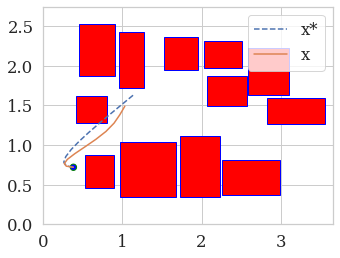

<Figure size 432x288 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [149]:
X_opt = optvals[0]
X_pin = pinvals[0]

plt.axes()
for obstacle in obstacles:
    rectangle = plt.Rectangle((obstacle[0], obstacle[2]), \
                              obstacle[1]-obstacle[0], obstacle[3]-obstacle[2], \
                             fc='red', ec='blue')
    plt.gca().add_patch(rectangle)
    plt.axis('scaled')

circle = plt.Circle((prob_params['x0'][0],prob_params['x0'][1]), 0.04, fc='blue',ec="green")
plt.gca().add_patch(circle)

plt.plot(X_opt[0,:], X_opt[1,:], linestyle='--', label='x*')
plt.plot(X_pin[0,:], X_pin[1,:], linestyle='-', label='x')
plt.legend(loc='best')

ax = plt.gca()
ax.margins(0)
ax.set(xlim=(posmin[0],posmax[0]), ylim=(posmin[1],posmax[1]))
fig = plt.figure()
plt.show()

plt.figure(figsize=(20,10))

figure = ax.get_figure()
# figure.savefig("fig_2b.png")

In [154]:
ft2m = 0.3048
posmax = ft2m*np.array([12.,9.])
max_box_size = 0.75
min_box_size = 0.25
box_buffer = 0.025
border_size = 0.05

posmin, posmax = mlopt_cnn.problem.posmin, mlopt_cnn.problem.posmax
velmin, velmax = mlopt_cnn.problem.velmin, mlopt_cnn.problem.velmax

In [ ]:
NPROBS = 500

batch_percent_success = {}
batch_true_cost = {}
batch_cost = {}
batch_cost_ratio = {}

for N_OBS in range(8, 17):
    n_solved = 0.
    success_count = 0.

    toggle_obstacles = True
    toggle_count = 0

    batch_true_cost[N_OBS] = []
    batch_cost[N_OBS] = []
    batch_cost_ratio[N_OBS] = []
    
    mlopt_cnn.problem.n_obs = N_OBS
    mlopt_cnn.problem.init_mlopt_problem()
    mlopt_cnn.problem.init_bin_problem()
    
    while n_solved < NPROBS:
        if toggle_obstacles:
            x0 = np.hstack((posmin + (posmax-posmin)*np.random.rand(2), \
                       velmin + (velmax-velmin)*np.random.rand(2)))
            obstacles = find_obs(x0, posmin, \
                posmax, mlopt_cnn.problem.n_obs)
            if len(obstacles) is not N_OBS:
                continue
        else:
            obstacles = random_obs(N_OBS, posmin, posmax, border_size, \
              min_box_size, max_box_size)
            x0 = findIC(obstacles, posmin, posmax, velmin, velmax)

        obstacles = np.reshape(np.concatenate(obstacles, axis=0), (mlopt_cnn.problem.n_obs,4)).T

        prob_params = {}
        prob_params['x0'] = x0
        prob_params['obstacles'] = obstacles
        prob_params['xg'] = np.hstack((0.9*posmax, np.zeros(2)))

        try:
            prob_success, true_cost, solve_time, optvals = mlopt_cnn.problem.solve_micp(prob_params)
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print('Solver failed for MICP')
            gurobi_mlopt_fail += 1
            continue

        if not prob_success:
            continue

        try:
            prob_success, cost, total_time, n_evals, mlopt_vals = mlopt_cnn.forward(prob_params)
        except (KeyboardInterrupt, SystemExit):
            raise
        except:
            print('Solver failed for QCQP')
            gurobi_mlopt_fail += 1
            continue

        if prob_success:
            success_count += 1
            batch_true_cost[N_OBS] += [true_cost]
            batch_cost[N_OBS] += [cost]
            batch_cost_ratio[N_OBS] += [cost / true_cost]
            toggle_count += 1
            if toggle_count % 5 == 0:
                toggle_obstacles = not toggle_obstacles

        n_solved+=1

    batch_percent_success[N_OBS] = success_count / NPROBS
    print('{} for n_obs={}'.format(batch_percent_success[N_OBS], N_OBS))

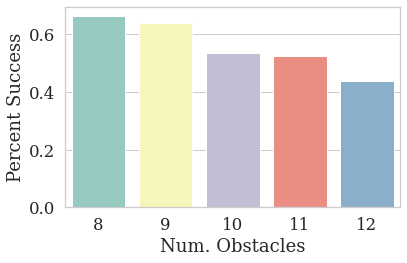

In [163]:
results = {}
for ii in range(8, 13):
    results[str(ii)] = [batch_percent_success[ii]]
results = pd.DataFrame(results)

ax1 = sns.barplot(data=results, palette="Set3", label='small')
ax1.set(xlabel="Num. Obstacles", ylabel="Percent Success")

plt.tight_layout()

figure = ax1.get_figure()
figure.savefig("generalization_percent_success.pdf")

In [32]:
batch_percent_success

{8: 0.788,
 9: 0.728,
 10: 0.752,
 11: 0.64,
 12: 0.676,
 13: 0.622,
 14: 0.616,
 15: 0.58,
 16: 0.578}

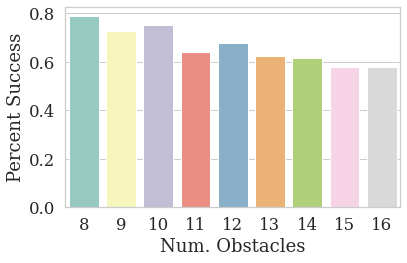

In [155]:
results = {}
for ii in range(8, 17):
    results[str(ii)] = [batch_percent_success[ii]]
results = pd.DataFrame(results)

ax1 = sns.barplot(data=results, palette="Set3", label='small')
ax1.set(xlabel="Num. Obstacles", ylabel="Percent Success")

plt.tight_layout()

figure = ax1.get_figure()
figure.savefig("generalization_percent_success.pdf")

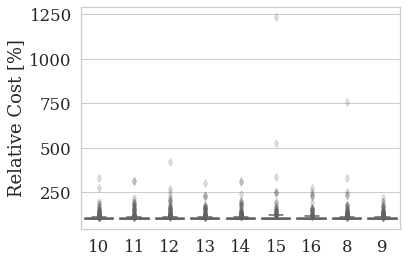

In [156]:
results = {}
results['Policy'] = []
results['Costs'] = []
for ii in range(8, 17):
    results['Policy'] += [str(ii)]*len(batch_cost_ratio[ii])
    results['Costs']  += batch_cost_ratio[ii]
results['Costs'] = 100.*np.array(results['Costs'])

results = pd.DataFrame(results)

ax1 = sns.boxplot(x=results['Policy'], y=results['Costs'], palette="Set3", flierprops=flierprops)
ax1.set(xlabel="", ylabel="Relative Cost [%]")

plt.tight_layout()
# plt.ylim(0, int(math.ceil(np.max(np.maximum(costs_ip, costs_naive_mlopt, costs_mlopt)) / 10.0)) * 10)

figure = ax1.get_figure()
figure.savefig("generalization_cost_ratios.pdf")